## Short Term Wind Climate 
**5. Filter data: (report page 30 - 33)**
- Outliers in wind speed and direction 
- Datagaps: Done in 'Overwiev'

**6. Interpolate:**
- Interpolate to the  one height of interest (= 150 meters for current turbine)

**7. Compare the both met masts:**
- Scatterplot: windspeed 150 m height mast one against windspeed 150m height mast 2 
- Same with the wind direction 
- Correlate with r^2 - linear correlation for both

**8. Short Term Wind Analysis**
- Mean, stdv of monthly and annual ws 
- Wind roses 
- Select parameters for Weibull model 
- Plot Weibull model 
- Diurnal profile of wind speed (blue) and wind direction (red) at HKW at 100 m MSL
- Monthly profile of the wind speed 
- Power curve of such a turbine
- Annual production of one turbine
- Annual production of wind farm


### Import Libraries and Load Data 

In [70]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
from scipy.stats import linregress


In [71]:
# Data Paths
bouy6_path = 'data/measurements/2023-11-06_Buoy6_BSH_N-9.nc'
bouy2_path = 'data/measurements/2023-11-09_Buoy2_BSH_N-9.nc'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
shapefiles_DEU_path = 'data/shapefiles/DEU/*'
shapefiles_DNK_path = 'data/shapefiles/DNK/*'
shapefiles_NLD_path = 'data/shapefiles/NLD/*'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

From 'Overview' we decided to work with: buoy_6_measured and buoy_2_correlated_with_6 bcs. buoy 2 had a lot of data gaps (not a complete year measured)

In [72]:
#Load the datafiles in xr and netcdf 

xrbuoy6 = xr.open_dataset(bouy6_path)
xrbuoy2 = xr.open_dataset(bouy2_path)

buoy2_file = Dataset(bouy2_path)
buoy6_file = Dataset(bouy6_path)

In [73]:
#xrbuoy2

In [74]:
#xrbuoy6

In [75]:
# select the data of interest for now
time2 = xrbuoy2.variables['time'][:]
windspeed2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_speed'][:]
winddirection_buoy_2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_from_direction'][:]

In [76]:
time6 = xrbuoy6.variables['time'][:]
windspeed6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_speed'][:]
winddirection_buoy_6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_from_direction'][:]

### 4. Filter the Data

In [77]:
#Filter all NaN values consistent! 
def filter_nan_values(arr):
    return arr[~np.isnan(arr)]

def filter_time_nan(time_variable):
    valid_time_rows = time_variable.astype('str') != 'NaT'
    filtered_time_variable = time_variable[valid_time_rows]
    return filtered_time_variable

def filter_and_align_data(time_var, wind_speed_var, wind_direction_var):
    valid_indices = ~np.isnan(time_var) & ~np.isnan(wind_speed_var) & ~np.isnan(wind_direction_var)
    filtered_time = time_var[valid_indices]
    filtered_wind_speed = wind_speed_var[valid_indices]
    filtered_wind_direction = wind_direction_var[valid_indices]
    return filtered_time, filtered_wind_speed, filtered_wind_direction

def process_wind_data_nan(time, winddirection, windspeed):
    # Initialize empty lists to store the results
    wd_nanfilters = []
    ws_nanfilters = []
    time_filtered = []
  

    # Loop over the range of indices and filter NaN values
    for i in range(0, 6):
        t, ws, wd = filter_and_align_data(time, windspeed[:, 0, 0, i], winddirection[:, 0, 0, i])
        time_filtered.append(t)
        ws_nanfilters.append(ws)
        wd_nanfilters.append(wd)


    # #Print the length of the original arrays
    # print(f'The original length of time array: {len(time)}')
    # print(f'The original length of winddirection array: {len(winddirection)}')
    # print(f'The original length of windspeed array: {len(windspeed)}')

    # # Print the length of the filtered arrays and absolute filtered values
    # for i, (filtered_time, filtered_ws, filtered_wd) in enumerate(zip(time_filtered, ws_nanfilters, wd_nanfilters)):
    #     print(f'The length of timefiltered{i+1} array: {len(filtered_time)}')
    #     print(f'The length of ws_nanfilter{i+1} array: {len(filtered_ws)}')
    #     print(f'The length of wd_nanfilter{i+1} array: {len(filtered_wd)}')
    
    return  time_filtered, wd_nanfilters, ws_nanfilters

time2_filtered, wd2_nanfilters, ws2_nanfilters = process_wind_data_nan(time2, winddirection_buoy_2, windspeed2)
time6_filtered, wd6_nanfilters, ws6_nanfilters = process_wind_data_nan(time6, winddirection_buoy_6, windspeed6)

### 6. Interpolate

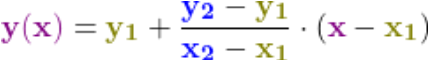

In [80]:
def interpolate_arrays(array1, array2, height1, height2, target_height):

    min_length = min(len(array1), len(array2))
    array1 = array1[:min_length]
    array2 = array2[:min_length]

    # Calculate the interpolation factor
    factor = (target_height - height1) / (height2 - height1) #factor = (x-x1)/(x2-x1)
    # Perform the interpolation
    interpolated_array = array1 + factor * (array2 - array1) #formular: y1 + factor *(y2 - y1)

    return interpolated_array

ws6_150m = interpolate_arrays(ws6_nanfilters[3], ws6_nanfilters[4], 140, 200, 150)
wd6_150m = interpolate_arrays(wd6_nanfilters[3], wd6_nanfilters[4], 140,200, 150 )
ws2_150m = interpolate_arrays(ws2_nanfilters[3], ws2_nanfilters[4],  140,200, 150 )
wd2_150m = interpolate_arrays(wd2_nanfilters[3], wd2_nanfilters[4],  140,200, 150 )

#test if they have the same shape 
print(ws6_150m.shape)
print(wd6_150m.shape)
print(time6_filtered[4].shape)
print()
print(ws2_150m.shape)
print(wd2_150m.shape)
print(time2_filtered[4].shape)


(55199,)
(55199,)
(55199,)

(55130,)
(55130,)
(55130,)


### 7. Compare Buoy 2 and Bouy 6 
- R2=1: This indicates a perfect fit, meaning that the regression line explains 100% of the variance in the dependent variable.
- 0.9≤R^2<1: Indicates an excellent fit, suggesting that the model explains a very high proportion of the variance.
- 0.7≤R^2<0.9: Indicates a good fit, suggesting that the model explains a substantial proportion of the variance.
- 0.5≤R^2<0.7: Indicates a moderate fit, meaning the model explains a reasonable amount of the variance, but there is still significant unexplained variance.
- R^2<0.5: Indicates a poor fit, suggesting that the model does not explain much of the variance in the dependent variable.

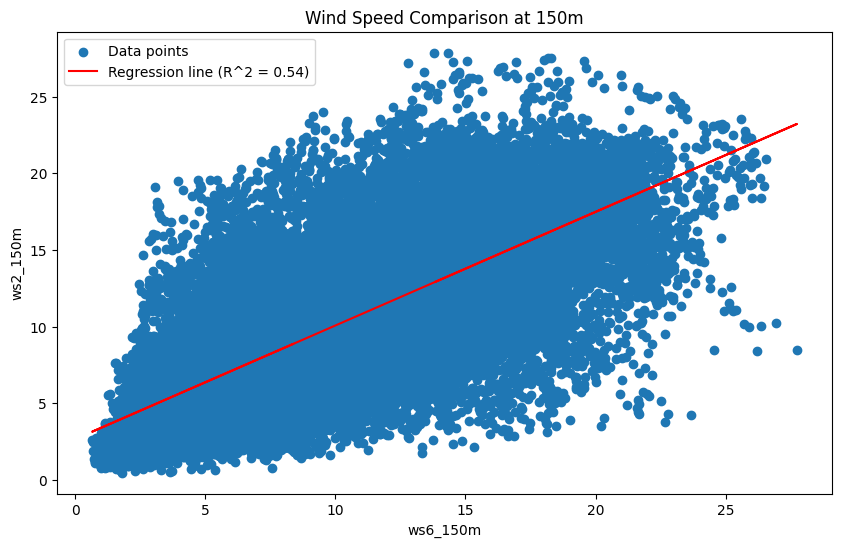

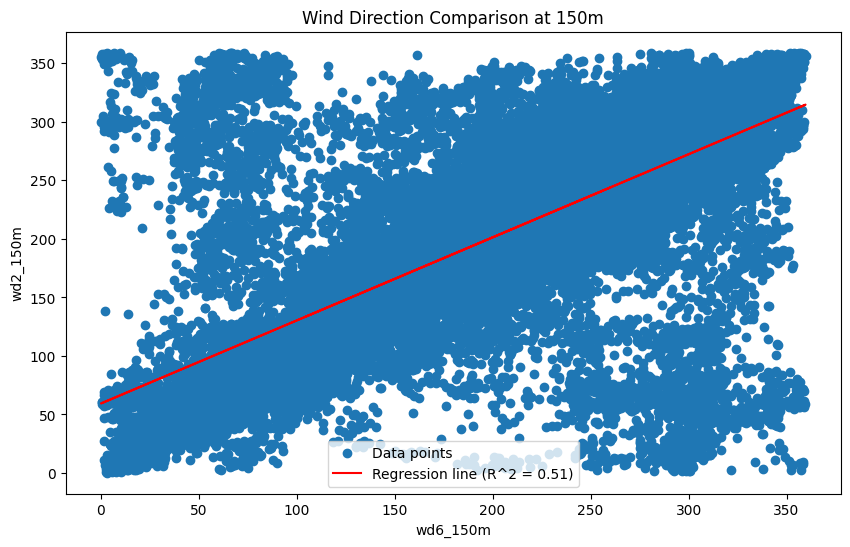

In [79]:
import matplotlib.pyplot as plt

# def trim_arrays(x, y):
#     min_length = min(len(x), len(y))
#     return x[:min_length], y[:min_length]


def plot_scatter_with_regression(x, y, xlabel, ylabel, title):
   # x, y = trim_arrays(x, y)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label='Data points')

    # Plot regression line
    plt.plot(x, slope * x + intercept, color='red', label=f'Regression line (R^2 = {r_value**2:.2f})')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Scatter plot for wind speed
plot_scatter_with_regression(ws6_150m[:52704], ws2_150m[:52704], 'ws6_150m', 'ws2_150m', 'Wind Speed Comparison at 150m') #52704 intervall points for one year 

# Scatter plot for wind direction
plot_scatter_with_regression(wd6_150m[:52704], wd2_150m[:52704], 'wd6_150m', 'wd2_150m', 'Wind Direction Comparison at 150m')


### 8. Short Term Wind Analysis for the interpolated 150m height


In [93]:
#mean, stdv, of annual ws 
mean_ws6 = np.mean(ws6_150m[:52704])
stdv_ws6 = np.std(ws6_150m[:52704])

mean_ws2 = np.mean(ws2_150m[:52704])
stdv_ws2 = np.std(ws2_150m[:52704])

print(f'Yearly Mean of ws Bouy_6: {mean_ws6:.2f}, Standard Deviation Buoy 6: {stdv_ws6:.2f}')
print(f'Yearly Mean of ws Bouy_2: {mean_ws2:.2f}, Standard Deviation Buoy 6: {stdv_ws2:.2f}')

#mean, stdv, of monthly ws 

def divide_into_bins_and_calculate_statistics(data, num_bins):
    # Ensure the dataset can be evenly divided into bins
    assert len(data) % num_bins == 0, "Dataset length must be divisible by the number of bins."
    
    # Calculate the size of each bin
    bin_size = len(data) // num_bins
    
    # Initialize lists to store the means and standard deviations of each bin
    bin_means = []
    bin_stds = []
    
    # Iterate through each bin
    for i in range(num_bins):
        # Determine the start and end indices of the bin
        start_idx = i * bin_size
        end_idx = start_idx + bin_size
        
        # Extract the bin data
        bin_data = data[start_idx:end_idx]
        
        # Calculate the mean of the bin
        bin_mean = np.mean(bin_data)
        
        # Calculate the standard deviation of the bin
        bin_std = np.std(bin_data)
        
        # Append the mean and standard deviation to their respective lists
        bin_means.append(bin_mean)
        bin_stds.append(bin_std)
    
    return bin_means, bin_stds


monthly_means_ws6, monthly_stds_ws6 = divide_into_bins_and_calculate_statistics(ws6_150m[:52704], 12)
monthly_means_ws2, monthly_stds_ws2 = divide_into_bins_and_calculate_statistics(ws2_150m[:52704], 12)


# Print the results with formatting
print("Monthly Means for Buoy 6:")
print([f"{mean:.2f}" for mean in monthly_means_ws6])

print("Monthly Standard Deviations for Buoy 6:")
print([f"{std:.2f}" for std in monthly_stds_ws6])


print("Monthly Means for Buoy 2:")
print([f"{mean:.2f}" for mean in monthly_means_ws2])

print("Monthly Standard Deviations for Buoy 2:")
print([f"{std:.2f}" for std in monthly_stds_ws2])


Yearly Mean of ws Bouy_6: 9.97, Standard Deviation Buoy 6: 4.46
Yearly Mean of ws Bouy_2: 10.05, Standard Deviation Buoy 6: 4.50
Monthly Means for Buoy 6:
['9.12', '9.36', '8.75', '8.45', '8.72', '7.44', '10.11', '11.44', '11.52', '12.60', '12.23', '9.93']
Monthly Standard Deviations for Buoy 6:
['4.40', '4.48', '3.92', '3.40', '2.85', '3.01', '4.89', '3.61', '4.23', '5.02', '5.35', '4.20']
Monthly Means for Buoy 2:
['9.16', '9.42', '8.91', '8.63', '8.75', '7.62', '10.33', '11.48', '11.33', '12.77', '12.20', '10.03']
Monthly Standard Deviations for Buoy 2:
['4.36', '4.45', '4.04', '3.55', '2.92', '3.23', '4.89', '3.73', '4.45', '4.91', '5.38', '4.29']


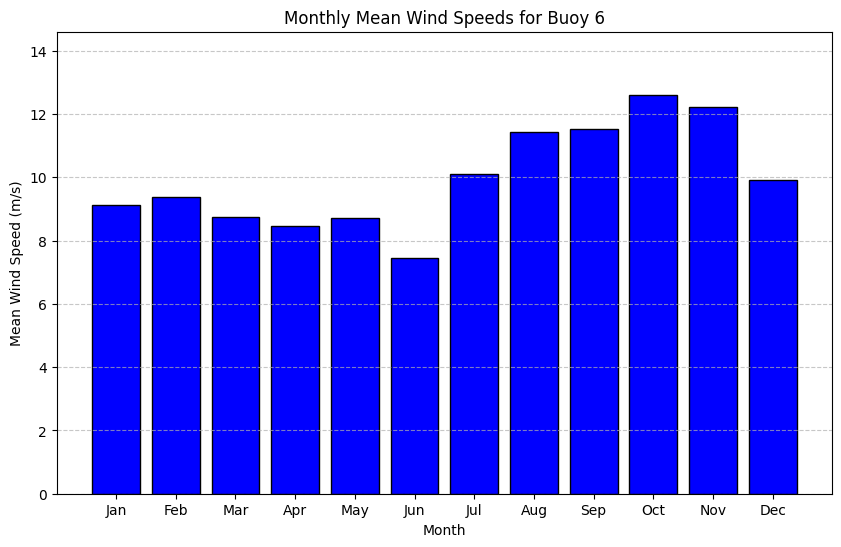

In [96]:
#plot bouy 6 monthly means 
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the monthly mean wind speeds
plt.figure(figsize=(10, 6))
plt.bar(months, monthly_means_ws6, color='blue', edgecolor='black')
plt.title('Monthly Mean Wind Speeds for Buoy 6')
plt.xlabel('Month')
plt.ylabel('Mean Wind Speed (m/s)')
plt.ylim(0, max(monthly_means_ws6) + 2)  # Adjust y-axis limit for better visualization
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

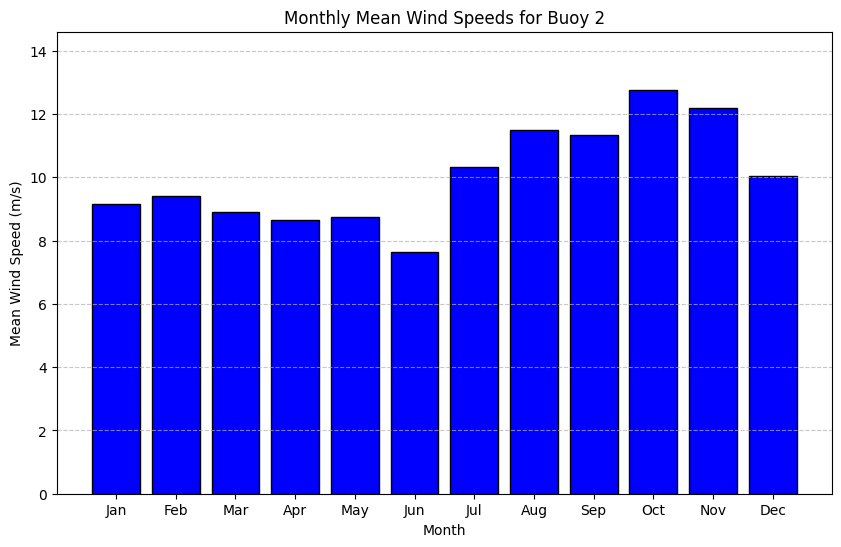

In [97]:
#plot bouy 6 monthly means 
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the monthly mean wind speeds
plt.figure(figsize=(10, 6))
plt.bar(months, monthly_means_ws2, color='blue', edgecolor='black')
plt.title('Monthly Mean Wind Speeds for Buoy 2')
plt.xlabel('Month')
plt.ylabel('Mean Wind Speed (m/s)')
plt.ylim(0, max(monthly_means_ws6) + 2)  # Adjust y-axis limit for better visualization
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()